## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import (
    DataGenerator,
    SimpleDataGenerator,
    ChainDependencies,
    TreeDependencies
)
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating a dataset

In [2]:
np.random.seed(123)
N = 1000
M = 15
K = 2

In [3]:
# deps_graph = ChainDependencies(M)
deps_graph = TreeDependencies(M, edge_prob=1.0)
deps_graph.edges

[(0, 1),
 (0, 2),
 (1, 3),
 (3, 4),
 (1, 5),
 (1, 6),
 (0, 7),
 (3, 8),
 (4, 9),
 (4, 10),
 (3, 11),
 (7, 12),
 (8, 13),
 (7, 14)]

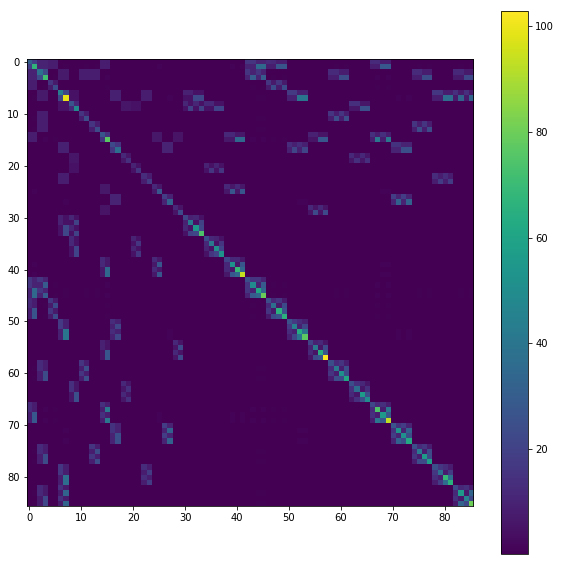

In [4]:
# data = DataGenerator(N, M, k=K, deps_graph=deps_graph)
data = SimpleDataGenerator(N, M, k=K, deps_graph=deps_graph)
visualize_matrix(np.abs(data.sig_inv))

### Testing the new `SimpleDataGenerator`

In [5]:
i,j = data.edges[0]

probs = [data.P_cond(i, y, Y=1) for y in range(K+1)]
print(sum(probs))
probs

1.0


[0.3188861687848412, 0.5536541625241326, 0.12745966869102618]

Independence of abstains implies $P(X_i, X_j \neq 0) = P(X_i)P(X_j \neq 0)$, which we use in recovery of the binary clique marginal probabilities later on:

In [6]:
data.P_cond((i,j), (1,1), Y=1) + data.P_cond((i,j), (1,2), Y=1)

0.3768230277490706

In [7]:
data.P_cond(i, 1, Y=1) * (1 - data.P_cond(j, 0, Y=1))

0.37682302774907067

### Forming squashed version

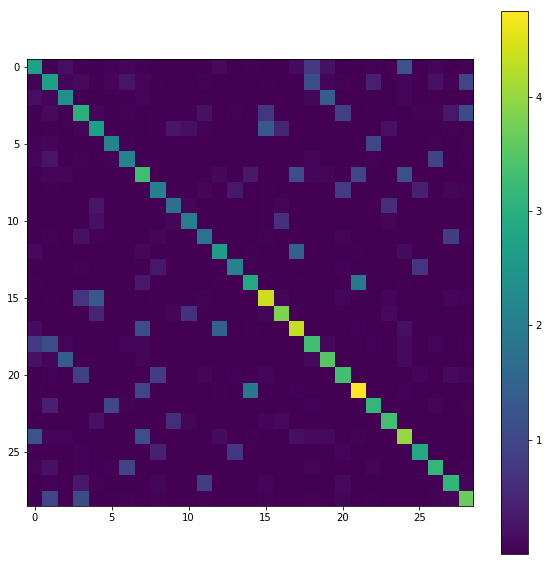

In [8]:
R = data.c_tree.R
R_mu = R @ data.mu
O_vis = R @ data.O @ R.T

S = R @ data.sig @ R.T
S_inv = np.linalg.inv(S)
visualize_matrix(np.abs(S_inv))

### Recovering $R\mu$

In [9]:
data.k = 1

lm = LabelModel(k=data.k, class_balance=data.p)

lm.train(
    data.L,
    deps=data.edges,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=10000,
    print_every=2000,
    lr=0.001,
    l2=0,
    O=O_vis,
    c_data=data.c_tree.c_data_1
)

1
Estimating Z...
[Epoch 0] Loss: 1088.308228
[Epoch 2000] Loss: 0.574214
[Epoch 4000] Loss: 0.574214
[Epoch 6000] Loss: 0.574214
[Epoch 8000] Loss: 0.574214
[Epoch 9999] Loss: 0.574214
Estimating \mu...
[Epoch 0] Loss: 32.621189
[Epoch 2000] Loss: 0.000000
[Epoch 4000] Loss: 0.000000
[Epoch 6000] Loss: 0.000000
[Epoch 8000] Loss: 0.000000
[Epoch 9999] Loss: 0.000000


In [10]:
R_mu_est = lm.mu.detach().numpy()
err = np.mean(np.abs(np.abs(R_mu_est) - np.abs(R_mu)))
print(f"Average absolute error in R\mu: {err}")

# We assume we have access to the total rate of non-abstains, which is observable
R_sum = data.c_tree.R_sum
mu_lp = (data.mu.T @ R_sum.T).T

mu_est = data.c_tree.recover_mu(R_mu_est, mu_lp)
err_mu = np.mean(np.abs(np.abs(mu_est) - np.abs(data.mu)))
print(f"Average absolute error in \mu: {err_mu}")

mu_est = data.c_tree.recover_mu(-R_mu_est, mu_lp)
err_mu = np.mean(np.abs(np.abs(mu_est) - np.abs(data.mu)))
print(f"Average absolute error in \mu [sign flipped]: {err_mu}")

Average absolute error in R\mu: 0.011549462474034307
Average absolute error in \mu: 0.1740143844314815
Average absolute error in \mu [sign flipped]: 0.004251512467904009
